In [1]:
from __future__ import division

import sys
import os
import h5py
import glob
import tqdm
import time 
import pickle
import numpy as np
from math import sqrt
from matplotlib import image
import matplotlib.pyplot as plt
import multiprocessing as mp
# from keras.models import load_model

# import python library
sys.path.append(os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'py'))

from cfar_detector import CFARDetector
from database import Database

class DetectorGenerator(Database):
    # Attributes
    __train, __test = None, None
    __train_test_file = 'train_test.pickle'
    __dataset_location = None
    __result_location = None
    __site = None
    # Initializer
    def __init__(self, dataset_location, database_location, result_location, site):
        self.__dataset_location = dataset_location
        self.__result_location = result_location
        self.__site = site
        super().__init__(dataset_location, database_location, site)
        
        
    ###############################
    """CROSS-CORRELATION RESULTS"""
    
    def get_sample_corr(self, params):
        """Get result of cross-correlation and target indices
        Param
            params: parameters passed by multiprocessing correlation generator
        Result
            file: name of file sample
            corr: result of correlation
            noise_ix: index of noise cut
            target_ix: index of target cut"""
        sample = params[0]
        corr = sample.get_corr(transforms=params[1], transforms_params=params[2], kernel=params[3])
        cuts, w, _ = sample.cuts(cut_time=0.2, cut_time_split=1.5, cut_freq=8, cut_freq_min=1.5, time_err=1, noise=True)
        noise_ix = np.array([[c[2],c[3]] for c in cuts[w:]])
        target_ix = np.array([[c[2],c[3]] for c in cuts[:w]])
        target_ix = target_ix[np.where(target_ix[:,1]<len(corr))]
        return [sample.get_file(), corr, noise_ix, target_ix]
    
    def generate_correlation(self, transforms, transforms_params, kernel_type='sim', train=True, save=True, n=None):
        """Generate all correlation results
        Param
            save: to save results to a file
            n: number of sample to process, None to process all sample
        Return
            results
        """
        # get files from either train or test
        files = self.get_train() if train else self.get_test()
        samples = np.array([CFARDetector(self.__dataset_location, self.__site, file) for file in files])#[int(len(files)*0.297):int(len(files)*0.299)]
        assert len(samples)>0, 'No samples'
        # load kernel
        kernel_mean_params = [os.path.join(self.get_database_location(), self.get_site(), 'kernels', 'kernel_data.h5')]
        kernel_sim_params = [0.35,80,1]
        kernel = samples[0].load_kernel(kernel_type,kernel_mean_params if kernel_type=='mean' else kernel_sim_params)
        # create multiprocessing methods
        pool = mp.Pool(mp.cpu_count())
        params = [[sample, transforms, transforms_params, kernel] for sample in samples][:n]
        results = []
        for result in tqdm.tqdm(pool.imap_unordered(self.get_sample_corr, params), total=len(params)):
            results.append(result)
        pool.close()
        pool.join()
        if save:
            self.save_generated_correlation(transforms, transforms_params, kernel_type,train,results)
        return results
    
    def save_generated_correlation(self, transforms, transforms_params, kernel_type,train,results):
        """Save results"""
        #create parameters dictionary
        data = {
            'transforms': transforms,
            'transforms_params': transforms_params, 
            'kernel_type': kernel_type, 
            'train': train, 
            'results': results
        }
        path = os.path.join(self.__result_location,self.get_site())
        try:
            os.makedirs(path)
        except OSError:
            pass
        file_name = '_'.join([str(transforms),str(transforms_params),str(kernel_type),str(train)])
        file_name += '.result'
        pickle.dump(data, open(os.path.join(path,file_name), 'wb'))
    
    def load_generated_correlation(self,transforms, transforms_params, kernel_type, train):
        """Load saved result containing all correlation"""
        file_name = '_'.join([str(transforms),str(transforms_params),str(kernel_type),str(train)])
        file_name += '.result'
        path = os.path.join(self.__result_location,self.get_site(),file_name)
        if not os.path.exists(path):
            raise Exception('%s does not exists.'%path)
        return pickle.load( open(path, "rb"))
    
    def load_generated_correlation_interference(self,transforms, transforms_params, kernel_type, train):
        """Load interference and target+interference of correlations
        Param
            ...
        Return
            target_data: contain target+interference of all correlation
            noise_data: contain interference of all correlation
        """
        results = self.load_generated_correlation(transforms, transforms_params, kernel_type, train)['results']
        target_data, noise_data = np.array([]), np.array([])
        for result in tqdm.tqdm(results):
            _, corr, noise_ix, target_ix = result
            for t in target_ix:
                target_data = np.concatenate((target_data,corr[t[0]:t[1]]))
            for n in noise_ix:
                noise_data = np.concatenate((noise_data,corr[n[0]:n[1]]))  
        return target_data, noise_data
    
    ######
    """"""
####### MATCHED FILTER
    def evaluate_detector(self,args):
        sample = args[0]
        return sample.evaluate_detector(transforms=args[1], transforms_params=args[2], 
                                        detector=args[3], detector_params=args[4],
                                        diff_err=args[5], time_err=args[6],
                                        kernel=args[7],
                                        segmented=args[8])

    
    def generate_kernel(self, sample, whistler, whistler_params):
        if whistler=='sim':
            return sample.whistler_sim(decay=whistler_params[0], 
                                       whistler_time=whistler_params[1], 
                                       whistler_freq_len=whistler_params[2], 
                                       whistler_freq_start=whistler_params[3], 
                                       thickness=whistler_params[4],
                                       size=whistler_params[5],
                                       freq_slice=whistler_params[6])
        elif whistler=='mean':
            pass
    
    def detector_metric(self, train, transforms, transforms_params, detector, detector_params, diff_err, time_err,
                         whistler, whistler_params, segmented, save=False):
        # get files from either train or test
        files = self.get_train() if train else self.get_test()
        samples = np.array([SampleDetector(self.__dataset_location, self.__site, file) for file in files])#[int(len(files)*0.297):int(len(files)*0.299)]
        assert len(samples)>0, 'No samples'
        # generate kernel
        kernel = self.generate_kernel(samples[0],whistler, whistler_params)
        # create multiprocessing methods
        pool = mp.Pool(mp.cpu_count())
        params = [[sample, transforms, transforms_params, detector, detector_params, diff_err, time_err, kernel, segmented] for sample in samples]
        results = []
        for result in tqdm.tqdm(pool.imap_unordered(self.evaluate_detector, params), total=len(params)):
            results.append(result)
        results = np.array(results)
        pool.close()
        pool.join()
        if save:
            self.save_detector_metric(train, transforms, transforms_params, detector, detector_params, diff_err, time_err,
                         whistler, whistler_params, segmented, results)
        return results
    
    def save_detector_metric(self, train, transforms, transforms_params, detector, detector_params, diff_err, time_err,
                         whistler, whistler_params, segmented, results):
        #create parameters dictionary
        data = {
            'transforms': transforms,
            'transforms_params': transforms_params, 
            'detector': detector, 
            'detector_params': detector_params,
            'whistler': whistler,
            'whistler_params': whistler_params, 
            'diff_err': diff_err, 
            'time_err': time_err,
            'segmented': segmented,
            'results': results
        }
        path = os.path.join(self.__result_location,self.get_site())
        try:
            os.makedirs(path)
        except OSError:
            pass
        file_name = '_'.join([str(train),str(transforms),str(transforms_params),str(detector),
                     str(detector_params),str(diff_err),str(time_err),str(whistler),str(whistler_params),str(segmented)])
        file_name += '.result'
        pickle.dump(data, open(os.path.join(path,file_name), 'wb'))
    
    def load_detector_metric(self,train, transforms, transforms_params, detector, detector_params, diff_err, time_err,
                         whistler, whistler_params,segmented):
        file_name = '_'.join([str(train),str(transforms),str(transforms_params),str(detector),
                     str(detector_params),str(diff_err),str(time_err),str(whistler),str(whistler_params),str(segmented)])
        file_name += '.result'
        path = os.path.join(self.__result_location,self.get_site(),file_name)
        if not os.path.exists(path):
            raise Exception('%s does not exists.'%path)
        return pickle.load( open(path, "rb"))

######### MACHINE LEARNING
    
    def ml_cnn_results(self, train, transforms, transforms_params, input_shape, scaler,model,save=True):
        """Generate all probability output of the cnn on the spectrograms"""
        # get files from either train or test
        files = self.get_train() if train else self.get_test()
        samples = np.array([SampleDetector(self.__dataset_location, self.__site, file) for file in files])#[int(len(files)*0.297):int(len(files)*0.299)]
        assert len(samples)>0, 'No samples'
        # create multiprocessing methods
        results = []
        for sample in tqdm.tqdm(samples):
            result = [sample.prob_output_ml(transforms, transforms_params, input_shape, scaler, model)]
            results.append(result)
        if save:
            self.save_prob_output_ml(train, transforms, transforms_params, input_shape, results)
        return results
    
    def ml_cnn_metric(self, train, transforms, transforms_params, input_shape, diff_err, time_err, window, threshold, e):
        data = self.load_prob_ouput_ml(train, transforms, transforms_params, input_shape)
        cnn_results = data['results']
        metric_results = []
        for cnn_result in tqdm.tqdm(cnn_results):
            file, prob, shift = cnn_result[0]
            sample = SampleDetector(self.get_dataset_location(), self.get_site(), file)
            result = sample.evaluate_detector_ml_cnn_ouput(prob, shift ,diff_err, time_err, window,threshold, e)
            metric_results.append(result)
        return np.array(metric_results)
            
    def load_prob_ouput_ml(self,train, transforms, transforms_params, input_shape):
        file_name = '_'.join([str(train),str(transforms),str(transforms_params),str(input_shape)])
        file_name += '.cnn_output'
        path = os.path.join(self.__result_location,self.get_site(),file_name)
        if not os.path.exists(path):
            raise Exception('%s does not exists.'%path)
        return pickle.load( open(path, "rb"))
    
    def save_prob_output_ml(self, train, transforms, transforms_params, input_shape, results):
        #create parameters dictionary
        data = {
            'transforms': transforms,
            'transforms_params': transforms_params, 
            'input_shape': detector, 
            'diff_err': diff_err, 
            'time_err': time_err,
            'results': results
        }
        path = os.path.join(self.__result_location,self.get_site())
        try:
            os.makedirs(path)
        except OSError:
            pass
        file_name = '_'.join([str(train),str(transforms),str(transforms_params),str(input_shape)])
        file_name += '.cnn_output'
        pickle.dump(data, open(os.path.join(path,file_name), 'wb'))
    
    def detector_metric_ml_single_proc(self, train, transforms, transforms_params, input_shape, scaler, model,
                        diff_err, time_err,save=True):
        # get files from either train or test
        files = self.get_train() if train else self.get_test()
        samples = np.array([SampleDetector(self.__dataset_location, self.__site, file) for file in files])#[int(len(files)*0.297):int(len(files)*0.299)]
        assert len(samples)>0, 'No samples'
        # create multiprocessing methods
        results = []
        for sample in tqdm.tqdm(samples):
            result = sample.evaluate_detector_ml(transforms, transforms_params, input_shape, scaler, model, diff_err, time_err)
            results.append(result)
        results = np.array(results)
        if save:
            self.save_detector_metric_ml(train, transforms, transforms_params, input_shape, diff_err, time_err,results)
        return results
    
    def save_detector_metric_ml(self, train, transforms, transforms_params, input_shape, diff_err, time_err, results):
        #create parameters dictionary
        data = {
            'transforms': transforms,
            'transforms_params': transforms_params, 
            'input_shape': detector, 
            'diff_err': diff_err, 
            'time_err': time_err,
            'results': results
        }
        path = os.path.join(self.__result_location,self.get_site())
        try:
            os.makedirs(path)
        except OSError:
            pass
        file_name = '_'.join([str(train),str(transforms),str(transforms_params),str(input_shape),
                    str(diff_err),str(time_err)])
        file_name += '.result'
        pickle.dump(data, open(os.path.join(path,file_name), 'wb'))
    
    def load_detector_metric_ml(self,train, transforms, transforms_params, input_shape, diff_err, time_err):
        file_name = '_'.join([str(train),str(transforms),str(transforms_params),str(input_shape),
                              str(diff_err),str(time_err)])
        file_name += '.result'
        path = os.path.join(self.__result_location,self.get_site(),file_name)
        if not os.path.exists(path):
            raise Exception('%s does not exists.'%path)
        return pickle.load( open(path, "rb"))

    
####
    def get_sample_per_metric_categories(results):
        metrics = np.array([r for r in results[:,2]])
        samples = np.array([r for r in results[:,0]])
        most_fp, most_fn, trash = [], [], []
        for sample, metric in zip(samples, metrics):
            most_fp.append(sample) if metric[2]>metric[0] else most_fn.append(sample)
            if metric[0]>metric[1] or metric[2]>metric[1]:
                trash.append(sample)
    
    def load_all_detector_metric(self):
        files = glob.glob(os.path.join(self.__result_location,self.get_site(),'*.result'))
        metrics = []
        for file in files:
            results = pickle.load( open(file, "rb"))['results']
            metrics.append([file,self.results(results),self.performance(results)])
        return np.array(metrics)
        
    def results(self, results):
        results = np.array([r for r in results[:,2]])
        return np.array([results[:,0].sum(),results[:,1].sum(),results[:,2].sum()])
    
    def performance(self, results):
        results = np.array([r for r in results[:,2]])
        false_negative, true_positive, false_positive = results[:,0].sum(),results[:,1].sum(),results[:,2].sum()
        precision = true_positive/(true_positive + false_positive)
        recall = true_positive/(true_positive + false_negative)
        f1_score = 2*(precision*recall/(precision+recall))
        g_measure = sqrt((true_positive/(true_positive+false_positive))*(true_positive/(true_positive+false_negative)))
        result = {
            'recall': np.round(recall,3),
            'precision': np.round(precision,3),
            'f1 score': np.round(f1_score,3),
            'g measure': np.round(g_measure,3),
            'false alarm': np.round(1-precision,3),
            'misdetection': np.round(1-recall,3)
        }
        return result

In [5]:
# dataset_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'awdEvents1')
# database_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','databases', 'awdEvents1')
# result_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','results', 'awdEvents1')
# site = 'marion'
# detector_gen = DetectorGenerator(dataset_loc, database_loc, result_loc, site)
# transforms=['slice','zscore']
# transforms_params=[[1.5,9.5],[None]]
# # detector_gen.generate_correlation(transforms, transforms_params, kernel_type='sim', train=True, save=True, n=None)
# data = detector_gen.load_generated_correlation(transforms, transforms_params, kernel_type='sim', train=True)
# target_data, noise_data = detector_gen.load_generated_correlation_interference(transforms, transforms_params, kernel_type='sim', train=True)
# target_data = 10*np.log10(target_data**1)
# noise_data = 10*np.log10(noise_data**1)  

100%|██████████| 1471/1471 [00:10<00:00, 140.11it/s]


Target+Interference: mean=36.654, std=5.275
Interference: mean=31.534, std=2.583
X_dB = 5.120


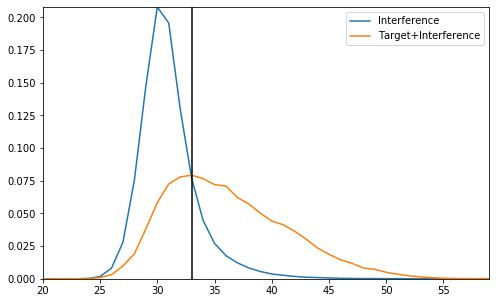

T = 33.000
X_dB = 10.239
Pfa=2.070e-04, Pd= 3.990e-01
Pfa=2.050e-01, Pd= 7.195e-01


In [9]:
# print('Target+Interference: mean=%.3f, std=%.3f'%(target_data.mean(), target_data.std()))
# print('Interference: mean=%.3f, std=%.3f'%(noise_data.mean(), noise_data.std()))
# print('X_dB = %.3f'%(target_data.mean()-noise_data.mean()))


# xmin, xmax = 20,60
# bins = np.linspace(xmin,xmax,xmax-xmin+1)
# noise_pdf, nbins = np.histogram(noise_data, bins=bins, density=True)
# target_pdf, tbins = np.histogram(target_data, bins=bins, density=True)

# plt.figure(figsize=(8,5))
# plt.plot(nbins[:-1],noise_pdf)
# plt.plot(tbins[:-1],target_pdf)
# plt.legend(['Interference', 'Target+Interference'])
# T = xmin+np.argmax(target_pdf)
# plt.axvline(T, color='black')
# plt.autoscale(tight=True)
# plt.show()

# X_dB = 10.239
# N = 10
# pfa = (1/(1+(10**(X_dB/10))/(2*N)))**(2*N)
# ca = 2*N*(pfa**(-1/(2*N))-1)
# pd = (1+((ca/(2*N))/(1+X_dB)))**(-2*N)
# print('T = %.3f'%T)
# print('X_dB = %.3f'%X_dB)
# print('Pfa=%.3e, Pd= %.3e'%(pfa, pd))

# pfa = noise_pdf[T-xmin:].sum()
# pd = target_pdf[T-xmin:].sum()
# print('Pfa=%.3e, Pd= %.3e'%(pfa, pd))

In [77]:
# dataset_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'awdEvents1')
# database_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','databases', 'awdEvents1')
# result_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','results', 'awdEvents1')
# site = 'marion'
# my_detector = Detector(dataset_loc, database_loc, result_loc, site)
# my_sample = SampleDetector(dataset_loc, site, np.random.choice(my_detector.get_train(),1)[0])
# train=True 

# # MF
# freq_slice = [2.5,10]
# transforms=['slice','zscore']
# transforms_params=[freq_slice,[None]]
# diff_err=0.2
# time_err=0.2
# detector='tm_cfar'
# detector_params=[10,25,1e-6,10]
# whistler='sim'
# whistler_params=[3,0.7,7.5,2.5,1,25,freq_slice]
# segmented=False

# # my_detector.detector_metric(train, transforms, transforms_params, detector, detector_params, diff_err, 
# #                             time_err, whistler, whistler_params, segmented, save=True)

# # ML
# aug=True
# trans, trans_params = ['zscore'],[[None]]
# params = str(trans)+'_'+str(trans_params)
# params +='_aug' if aug else ''
# scaler_path = os.path.join(database_loc,site,'models',params+'_scaler.pickle')
# model_path = os.path.join(database_loc,site,'models',params+'_model.h5')
# input_shape = [48,108] # size at req_slice[2.5,10]
# scaler = pickle.load( open( scaler_path, "rb" ) )['scaler']
# # model = load_model(model_path)

# # results = my_detector.detector_metric_ml(train, transforms, transforms_params, input_shape, scaler, model, 
# #                             diff_err=diff_err, time_err=time_err, save=True)
# # results = my_detector.ml_cnn_results(train, transforms, transforms_params, input_shape, scaler, model)

In [82]:
# data = my_detector.load_prob_ouput_ml(train, transforms, transforms_params, input_shape)
# cnn_results = data['results']
# results = my_detector.ml_cnn_metric(train, transforms, transforms_params, input_shape, diff_err, time_err, window=10, threshold=0.6, e=-0.05)

100%|██████████| 1471/1471 [02:15<00:00, 10.43it/s]


In [83]:
# print(my_detector.results(results))
# print(my_detector.performance(results))

[ 398 2679  904]
{'recall': 0.871, 'precision': 0.748, 'f1 score': 0.805, 'g measure': 0.807, 'false alarm': 0.252, 'misdetection': 0.129}


In [84]:
# data = my_detector.load_detector_metric(train, transforms, transforms_params, detector,
#                                         detector_params,diff_err,time_err, whistler, 
#                                         whistler_params, segmented=False)
# _results = data['results']
# print(my_detector.results(_results))
# print(my_detector.performance(_results))

# data = my_detector.load_detector_metric_ml(train, transforms, transforms_params, input_shape, diff_err,time_err)
# _results = data['results']
# print(my_detector.results(_results))
# print(my_detector.performance(_results))

[ 833 2244  565]
{'recall': 0.729, 'precision': 0.799, 'f1 score': 0.762, 'g measure': 0.763, 'false alarm': 0.201, 'misdetection': 0.271}
[ 538 2539 1103]
{'recall': 0.825, 'precision': 0.697, 'f1 score': 0.756, 'g measure': 0.758, 'false alarm': 0.303, 'misdetection': 0.175}


In [31]:
# dataset_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'awdEvents1')
# database_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','databases', 'awdEvents1')
# result_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','results', 'awdEvents1')
# site = 'marion'
# my_detector = Detector(dataset_loc, database_loc, result_loc, site)

# freq_slice = [2.5,10]
# train=True 
# transforms=['slice','zscore']
# transforms_params=[freq_slice,[None]]
# detector='tm_cfar'
# detector_params=[10,25,1e-6,7]
# diff_err=0.3
# time_err=0.2
# whistler='sim'
# whistler_params=[3,0.7,7.5,2.5,1,25,freq_slice]
# segmented=False

# # for decay in [3,3.25,3.5,3.75,4]:
# #     for whistler_time in [0.5,0.6,0.7,0.8,0.9]:
# #             for N in [10,15,20,25,30]:
# #                 for G in [10,15,20,25,30]:
# # for pfa in [1e-1,1e-2,1e-3,1e-4,1e-5,1e-6]:
# # for pfa in [1e-2, 1e-3,1e-4,1e-5,1e-6]:
# #     for C in [6,7,8,9,10]:
# # for size in [10,25,40,50]:
# #     whistler_params=[3,0.7,7.5,2.5,1,size,freq_slice]
# #     my_detector.detector_metric(train, transforms, transforms_params, detector, detector_params, diff_err, 
# #                                                         time_err, whistler, whistler_params, segmented, save=True)
            
            
# # for pfa in [1e-1,1e-2,1e-3,1e-4,1e-5,1e-6]:
# #     for C in [0,3,5]:

# # for w in [0.5,0.65,0.8,1,1.5]:
    
# #     data = my_detector.load_detector_metric(train=True, transforms=['zscore'], transforms_params=[[None]], detector='tm_cfar', 
# #                                 detector_params=[10,15,1e-3,0], diff_err=0.3, time_err=0.2, whistler='sim', whistler_params=[w,0.8,7.5,2.5,1,90])
# #     results = data['results']
# #     print(my_detector.results(results))

In [60]:
# dataset_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'awdEvents1')
# database_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','databases', 'awdEvents1')
# result_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','results', 'awdEvents1')
# site = 'marion'
# my_detector = Detector(dataset_loc, database_loc, result_loc, site)
# results = my_detector.load_all_detector_metric()

In [89]:
# results
# arr = results[:,2]
# arr = np.array([r for r in arr])
# ix = np.argwhere(arr[:,3]==arr[:,3].max())
# results[ix]

array([[["/home/othniel/wdml/data/results/awdEvents1/marion/True_['slice', 'zscore']_[[2.5, 10], [None]]_tm_cfar_[10, 25, 1e-06, 10]_0.3_0.2_sim_[3, 0.7, 7.5, 2.5, 1, 25, [2.5, 10]]_False.result",
         array([ 783, 2294,  513]),
         array([0.81724261, 0.74553136, 0.77974167, 0.7805639 ])]]],
      dtype=object)

In [32]:
# for size in [10,25,40,50]:
#     whistler_params=[3,0.7,7.5,2.5,1,size,freq_slice]
#     data = my_detector.load_detector_metric(train, transforms, transforms_params, detector, 
#                         detector_params, diff_err, time_err, whistler, whistler_params, segmented)
#     results = data['results']
#     print((size),my_detector.results(results),my_detector.performance(results))

10 (1543, 1534, 100) (0.9388004895960832, 0.49853753656158595, 0.651241774570155, 0.684125195710582)
25 (936, 2141, 377) (0.8502779984114377, 0.6958076048098798, 0.7653261840929403, 0.7691748159535654)
40 (811, 2266, 590) (0.7934173669467787, 0.7364315892102697, 0.7638631383785606, 0.7643936240234112)
50 (768, 2309, 676) (0.773534338358459, 0.7504062398440039, 0.7617947871989442, 0.7618825330966649)
